In [12]:
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from skimage.feature import blob_dog

import matplotlib.pyplot as plt
%matplotlib widget

In [13]:

def show(img, title=None, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def draw_labeled_points(img, target, corners, color=(0, 0, 255)):
    result = img.copy() 
    
    def draw_point(img, point, label):
        cv2.circle(img, point, 1, color, -1)
        cv2.putText(img, label, (point[0] - 20, point[1] - 20), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    # Draw and label the target point
    draw_point(result, target, "Target")
    
    # Draw and label the corner points
    labels = ["TL", "TR", "BL", "BR"]
    for point, label in zip(corners, labels):
        draw_point(result, point, label)
    
    return result

In [14]:
def get_contour_center(contour):
    contour_points = contour.reshape(-1, 2)
    cX = int(contour_points[:, 0].mean())
    cY = int(contour_points[:, 1].mean())
    return (cX, cY)

def get_target_and_corners(binary_img):
    
    # Find and sort the contours in the binay image
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 0]
    filtered_contours = filtered_contours[:9] if len(filtered_contours) >= 9 else filtered_contours
 
    centers = [get_contour_center(c) for c in filtered_contours]
    
    # Perform K-means clustering
    if len(centers) >5: 
        kmeans = KMeans(n_clusters=5)
        kmeans.fit(centers)
        
        # Get the cluster centers
        centers = kmeans.cluster_centers_.astype(int)

    # Sort centers by x-coordinate
    sorted_by_x = sorted(centers, key=lambda p: p[0])

    # The middle point is the target
    target = sorted_by_x[2]  # Assuming we have exactly 5 points
    
    # Split the remaining points into left and right pairs
    left_pair = sorted_by_x[:2]
    right_pair = sorted_by_x[3:]
    
    # Sort left and right pairs by y-coordinate
    left_pair.sort(key=lambda p: p[1])
    right_pair.sort(key=lambda p: p[1])
    
    # Assign corners
    top_left, bottom_left = left_pair
    top_right, bottom_right = right_pair

    return target, [top_left, top_right, bottom_left, bottom_right]


def refine_centers(gray_img, lighting_state, thresh_values, centers):
    
    aoi_size = 40  # Size of the square AOI around each center
    half_aoi = aoi_size // 2
    
    # Process each AOI and get refined centers
    refined_centers = []
    
    # Process center point (first point) using ellipse fitting
    center = centers[0]
    x, y = center
    
    # Extract AOI with boundary checking for center point
    y1 = max(0, y - half_aoi)
    y2 = min(gray_img.shape[0], y + half_aoi)
    x1 = max(0, x - half_aoi)
    x2 = min(gray_img.shape[1], x + half_aoi)
    
    center_aoi = gray_img[y1:y2, x1:x2].copy()
    normalized = cv2.normalize(center_aoi, None, 0, 255, cv2.NORM_MINMAX)
    
    # Threshold for center point
    if lighting_state == "dark":
        _, binary = cv2.threshold(normalized, thresh_values, 255, cv2.THRESH_BINARY)
    else:
        _, binary = cv2.threshold(normalized, thresh_values, 255, cv2.THRESH_BINARY_INV)
    
    # Find points for ellipse fitting
    points = np.column_stack(np.where(binary > 0)[::-1])
    
    if len(points) > 5:
        # Fit ellipse to center point
        (center_x, center_y), (width, height), angle = cv2.fitEllipse(points)
        refined_centers.append((int(round(x1+center_x)), int(round(y1+center_y))))
    else:
        refined_centers.append(center)
    
    # Process corner points using blob detection
    for corner in centers[1:]:
        x, y = corner
        
        # Extract AOI for corner point
        y1 = max(0, y - half_aoi)
        y2 = min(gray_img.shape[0], y + half_aoi)
        x1 = max(0, x - half_aoi)
        x2 = min(gray_img.shape[1], x + half_aoi)
        
        corner_aoi = gray_img[y1:y2, x1:x2].copy()
        normalized = cv2.normalize(corner_aoi, None, 0, 255, cv2.NORM_MINMAX)
        
        if lighting_state == "dark":
            processed_aoi = normalized
        else:
            processed_aoi = 255 - normalized  # Invert for light background
            
        # Detect blobs
        blobs = blob_dog(processed_aoi, 
                        min_sigma=3,
                        max_sigma=7,
                        threshold=.1)
        
        if len(blobs) > 0:
            # Get the strongest blob (highest response)
            strongest_blob = blobs[np.argmax(blobs[:, 2])]
            y_blob, x_blob = strongest_blob[:2]
            
            # Add refined corner position (adjust for AOI offset)
            refined_centers.append((int(round(x1 + x_blob)), 
                                 int(round(y1 + y_blob))))
        else:
            refined_centers.append(corner)
    
    return refined_centers[0], refined_centers[1:]


In [15]:
def process_image(img, lighting_state, thresh_val):

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if lighting_state == "dark":
        _, binary_img = cv2.threshold(gray_img, thresh_val, 255, cv2.THRESH_BINARY)
    
    elif lighting_state == "bright":
        _, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        
        # Count non-zero pixels
        white_pixels = np.count_nonzero(thresh)
        total_pixels = thresh.shape[0] * thresh.shape[1]
        coverage_ratio = white_pixels / total_pixels

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Find largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros(thresh.shape, dtype=np.uint8)
        cv2.drawContours(mask, [largest_contour], 0, (255), thickness=cv2.FILLED)
        
        # Create eroded mask
        kernel = np.ones((25,25), np.uint8)
        eroded_mask = cv2.erode(mask, kernel, iterations=1)
        
        # Create final binary image
        _, thresh = cv2.threshold(gray_img, thresh_val, 255, cv2.THRESH_BINARY)
        inverted_thresh = cv2.bitwise_not(thresh)
        binary_img = cv2.bitwise_and(inverted_thresh, inverted_thresh, mask=eroded_mask)
    else:
        raise ValueError(f"Unsupported lighting state: {lighting_state}")

    _target, _corners = get_target_and_corners(binary_img)

    target, corners = refine_centers(gray_img, lighting_state, thresh_val, [_target] + _corners)
    
    labeled_image = draw_labeled_points(img, target, corners)
    
    return labeled_image, target, corners



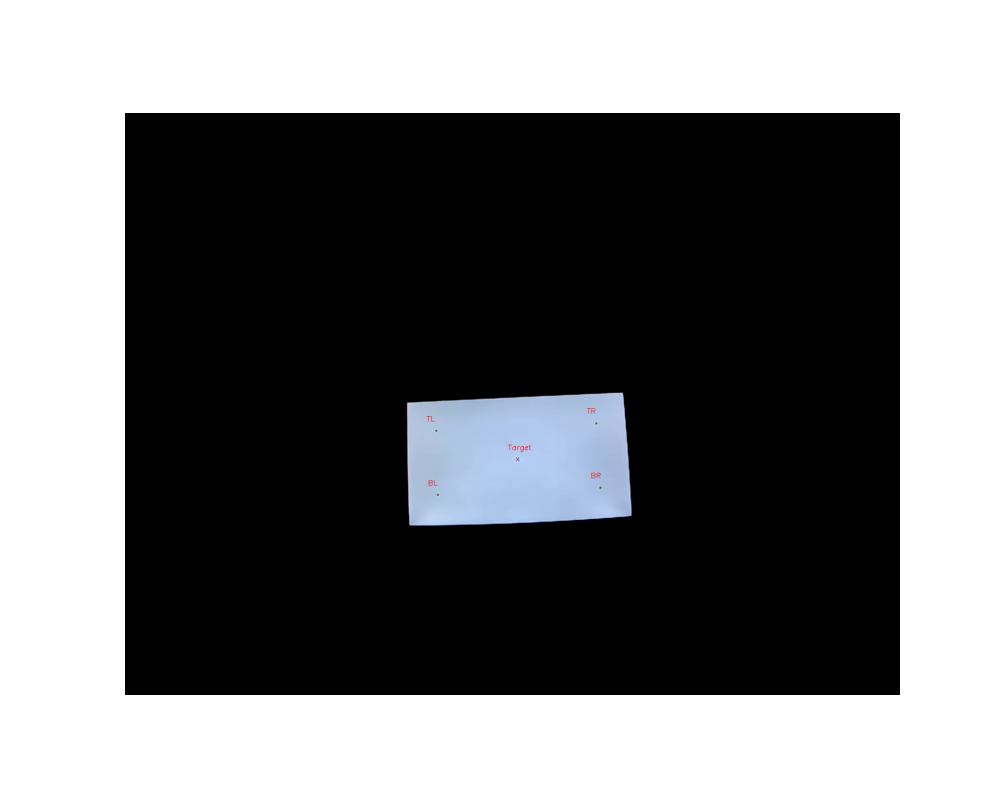

In [21]:

bright_img = cv2.imread(r'./bright.png')
labeled_image, target, corners = process_eye_tracking_image(bright_img, "bright", 150)
show(labeled_image)




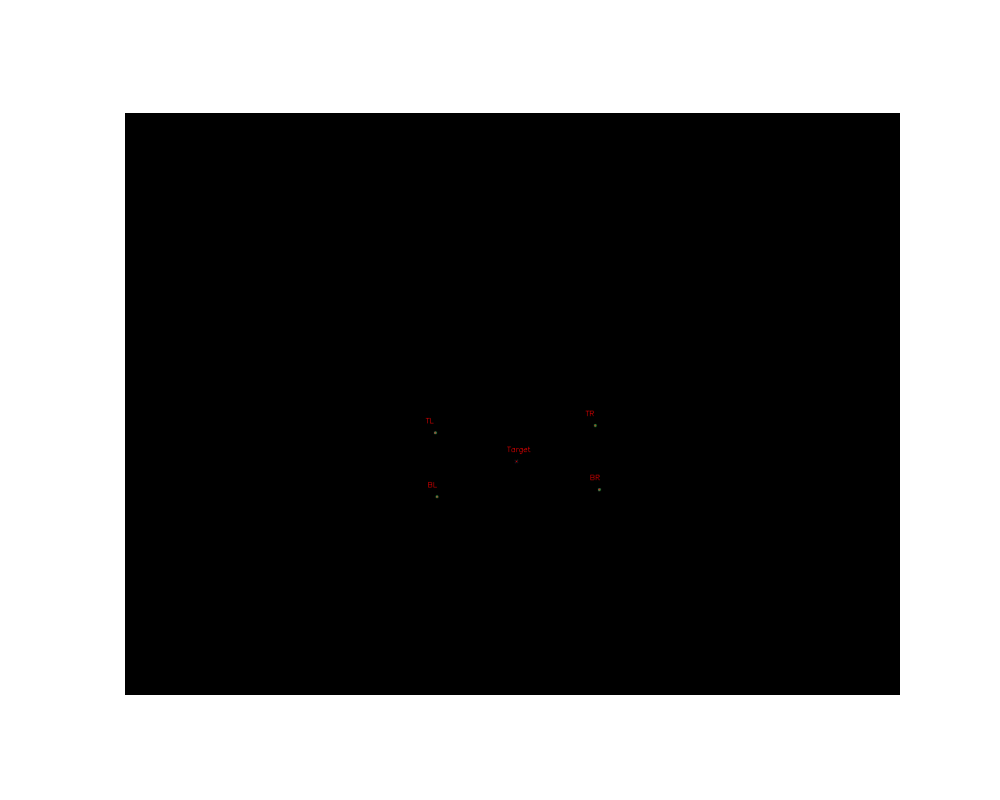

In [25]:
dark_img = cv2.imread(r'./dark.png')
labeled_image, target, corners = process_image(dark_img, "dark", 5)
show(labeled_image)